In [128]:
import numpy as np  # Load required libs
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm.notebook import tqdm
from torch.nn import ReLU, Conv2d, BatchNorm2d, Sequential, AdaptiveAvgPool2d, Linear, MaxPool2d, Flatten, ConvTranspose2d
from typing import Tuple, List, Type, Dict, Any, NoReturn
from threading import Thread, Lock
from queue import Empty, Queue
from sklearn.utils import shuffle
from torch.autograd import Variable
try:
    import adabelief_pytorch
except:
    !pip install adabelief_pytorch==0.2.0
    time.sleep(1)
    import adabelief_pytorch
import gc  # sometimes it is required to clean GPU memory in that way

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # We'd like to use GPU
device

device(type='cuda', index=0)

In [93]:
"""KARAMBA! Autoenc class made up with Sigmoid in the end, so Normalize is not required"""


transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                                            torchvision.transforms.RandomRotation(degrees=15),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.15,), (0.31,))])

transform_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                torchvision.transforms.Normalize((0.15,), (0.31,))])

In [94]:
train_mnist = torchvision.datasets.MNIST('', train=True, transform=transform_train, download=True)
test_mnist = torchvision.datasets.MNIST('', train=False, transform=transform_test, download=True)

In [95]:
def show_samples(ds):
    indices = np.random.randint(0, len(ds), size=8)

    fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(8, 2), dpi=300)
    for i, ax in enumerate(axes):
        sample_index = indices[i]
        sample = ds[sample_index][0]
        ax.imshow(np.squeeze(sample.cpu().numpy()), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    fig.patch.set_facecolor('white')

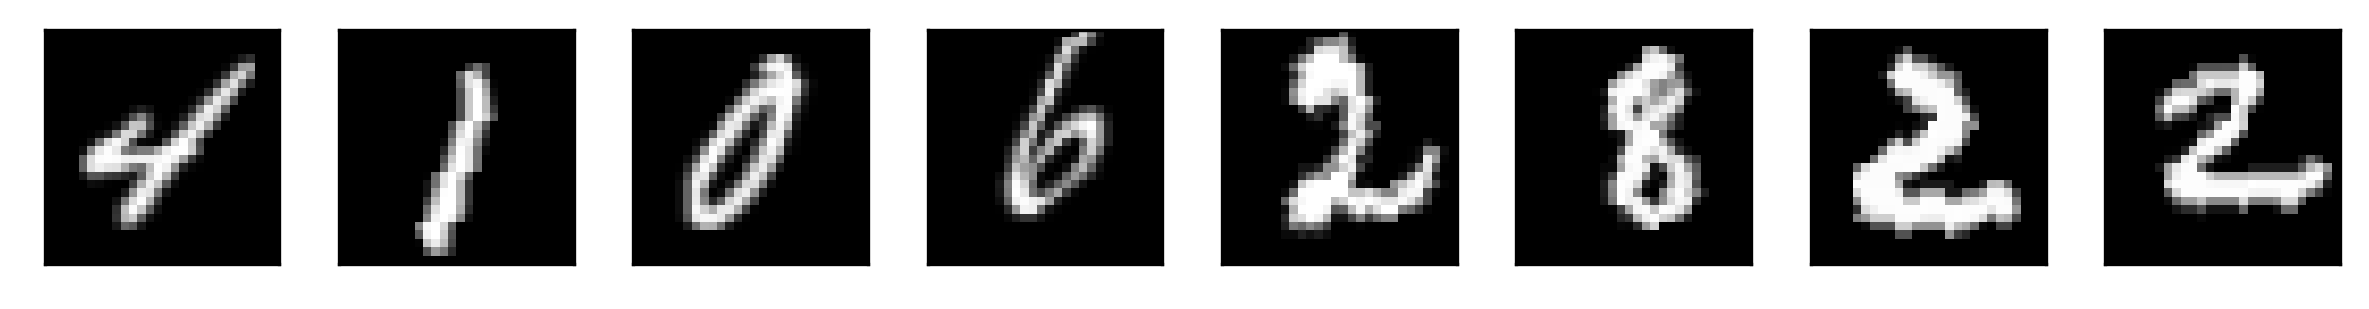

In [96]:
show_samples(train_mnist)

In [126]:
class Interpolator(torch.nn.Module):
    def __init__(self, output_size, interpolation_mode='bilinear'):
        super(Interpolator, self).__init__()
        self.output_size = output_size
        self.interpolation_mode = interpolation_mode
        
        
    def forward(self, img):
        return torch.nn.functional.interpolate(img, size=self.output_size, mode=self.interpolation_mode)

In [100]:
class FuckIt(torch.nn.Module):
    def __init__(self, hidden = 32):
        super(FuckIt, self).__init__()
        self.hidden = hidden
        
        self.act = ReLU()
        self.conv1 = Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.max1 = MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.conv2 = Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.max2 = MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.conv3 = Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.avg_pool = AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = Flatten()
        self.l1 = Linear(in_features=64, out_features=self.hidden)
        
        self.l2 = Linear(in_features=self.hidden, out_features=196)
        self.unflat = torch.nn.Unflatten(dim=1,
                                         unflattened_size=(4, 7, 7))
        self.up1 = torch.nn.Upsample(scale_factor=(2, 2), mode='bilinear')
        self.tconv1 = ConvTranspose2d(4, 16, 3, stride=1)
        self.up2 = torch.nn.Upsample(scale_factor=(2, 2), mode='bilinear')
        self.tconv2 = ConvTranspose2d(16, 1, 3, stride=1)
        
        self.final_resize = Interpolator(output_size=(28, 28))
        
        
    def forward(self, img):
        x = self.max1(self.act(self.conv1(img)))
        x = self.max2(self.act(self.conv2(x)))
        x = self.avg_pool(self.act(self.conv3(x)))
        x = self.flatten(x)
        x = self.l1(x)
        
        x = self.l2(x)
        x = self.unflat(x)
        x = self.act(self.tconv1(self.up1(x)))
        x = self.final_resize(self.tconv2(self.up2(x)))
        
        x = torch.sigmoid(x)
        
        return x
    
    def encode(self, img):
        x = self.max1(self.act(self.conv1(img)))
        x = self.max2(self.act(self.conv2(x)))
        x = self.avg_pool(self.act(self.conv3(x)))
        x = self.flatten(x)
        x = self.l1(x)
        
        return x

In [150]:
class Autoencoder(torch.nn.Module):
    def __init__(self,
                 hidden_size=32,
                 channels=[16, 32, 64],
                 act=ReLU,
                 start_spatial_size = 7):
        super(Autoencoder, self).__init__()
        
        self.act = act
        self.hidden_size = hidden_size
        self.channels = channels
        self.start_spatial_size = start_spatial_size
        
        self._make_encoder()
        self._make_decoder()
        
    def _make_encoder(self) -> NoReturn:
        previous_channel = 1
        blocks = []
        
        for channel in self.channels:
            blocks.append(Conv2d(previous_channel, channel, 3, stride=1, padding=1))
            blocks.append(self.act())
            blocks.append(MaxPool2d(2, stride=2, padding=1))
            
            previous_channel = channel
            
        blocks.append(AdaptiveAvgPool2d(output_size=(1, 1)))
        blocks.append(Flatten())
        blocks.append(Linear(self.channels[-1], self.hidden_size))
        blocks.append(self.act())
        
        self.encoder = Sequential(*blocks)
    
    def _make_decoder(self) -> NoReturn:
        blocks = []
        
        blocks.append(Linear(self.hidden_size, 4*(self.start_spatial_size ** 2)))
        blocks.append(self.act())
        blocks.append(torch.nn.Unflatten(dim=1,
                                         unflattened_size=(4,
                                                           self.start_spatial_size,
                                                           self.start_spatial_size)))
        
        out_spatial_size = self.start_spatial_size
        previous_channel = 4
        for channel in self.channels:
            out_spatial_size *= 2
            blocks.append(Interpolator(output_size=(out_spatial_size, out_spatial_size)))
            blocks.append(ConvTranspose2d(previous_channel, channel, 3, stride=1, padding=1))
            blocks.append(self.act())
            
            previous_channel = channel
        
        blocks.append(Interpolator(output_size=(28, 28)))
        blocks.append(ConvTranspose2d(self.channels[-1], 1, 3, stride=1, padding=1))
        blocks.append(torch.nn.Sigmoid())
        
        self.decoder = Sequential(*blocks)
    
    def encode(self, img) -> torch.Tensor:
        return self.encoder(img)
    
    def decode(self, hidden) -> torch.Tensor:
        return self.decoder(hidden)
    
    def forward(self, img) -> torch.Tensor:
        hidden = self.encode(img)
        reconstructed = self.decoder(hidden)
        
        return reconstructed

In [151]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       dataloader):
    model.train()
    size = len(dataloader.dataset)
    loss_val = 0
    
    with tqdm(total=len(dataloader)) as pbar:
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            pred = model(X)
            loss = loss_function(pred, X)
            loss_val += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.update()
            pbar.set_postfix({'step - ':batch, 'loss val - ':loss_val, 'loss on batch - ':loss.item()})
    loss_val = loss_val / size
    return loss_val

In [152]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          dataloader):
    model.eval()
    size = len(dataloader.dataset)
    val_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        pred = model(X)
        loss = loss_function(pred, X)
        val_loss += loss.item()
            
    val_loss /= size
    print('loss - {}'.format(val_loss))
    return {'loss': val_loss}

In [153]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = AutoencoderLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim.Adam,
                optimizer_params: Dict = {},
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ExponentialLR,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 100,
                early_stopping_patience = 10
):
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0)

    best_val_loss = None
    best_epoch = None
    
    with tqdm(total=max_epochs) as pbar:
        for epoch in range(max_epochs):
            train_single_epoch(model, optimizer, loss_function, train_loader)
            val_metrics = validate_single_epoch(model, loss_function, val_loader)

            lr_scheduler.step(val_metrics['loss'])
            pbar.update()
            pbar.set_postfix({'Epoch - ':epoch, 'Validation metrics - ':val_metrics})

            if best_val_loss is None or best_val_loss > val_metrics['loss']:
                print(f'Best model yet, saving')
                best_val_loss = val_metrics['loss']
                best_epoch = epoch
                torch.save(model, './best_model.pth')

            if epoch - best_epoch > early_stopping_patience:
                print('Early stopping triggered')
                return

In [158]:
autoencoder = Autoencoder().to(device)

print('Total number of trainable parameters : {}'.format(sum(parameter.numel() for parameter in autoencoder.parameters() if parameter.requires_grad)))

Total number of trainable parameters : 56149


In [175]:
train_model(autoencoder,
           train_mnist,
           test_mnist,
           loss_function=torch.nn.MSELoss(),
           optimizer_class=torch.optim.Adam,
           optimizer_params={'lr':0.001,
                             'betas':(0.9, 0.999),
                             'eps':1e-08,
                             'weight_decay':2e-4,
                             'amsgrad':False},
           lr_scheduler_class=torch.optim.lr_scheduler.ExponentialLR,
           lr_scheduler_params={'gamma':0.974},
           batch_size=32,
           max_epochs=5,
           early_stopping_patience=10)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

loss - 0.01714200730919838
Best model yet, saving


  0%|          | 0/1875 [00:00<?, ?it/s]

loss - 0.01733254435658455


  0%|          | 0/1875 [00:00<?, ?it/s]

loss - 0.017174130183458328


  0%|          | 0/1875 [00:00<?, ?it/s]

loss - 0.017156014463305475


  0%|          | 0/1875 [00:00<?, ?it/s]

loss - 0.017059664115309715
Best model yet, saving


tensor(1.0000, device='cuda:0')
tensor(0., device='cuda:0')


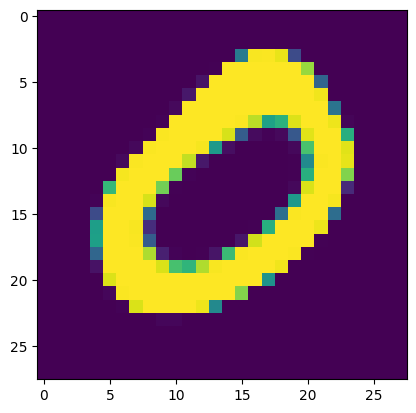

In [176]:
with torch.no_grad():
    img = train_mnist[1][0].reshape((1, 1, 28, 28)).to(device)
    reconstructed = autoencoder(img)
    print(torch.max(reconstructed))
    print(torch.min(reconstructed))
    plt.imshow(reconstructed[0][0].cpu())
    

In [182]:
def compare_imgs(autoencoder, ds, noise=0.2):
    indices = np.random.randint(0, len(ds), size=8)
    
    objects = list(ds[index] for index in indices)
    samples = list(obj[0] + noise*torch.randn((1, 28, 28)) for obj in objects)
    
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(32, 8))
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            if i == 0:
                sample = samples[j]
                ax.imshow(sample.cpu().numpy().transpose(1, 2, 0)[:,:,0], cmap='gray')
            else:
                sample = samples[j]
                with torch.no_grad():
                    sample = sample.reshape((1, 1, 28, 28)).to(device)
                    sample = autoencoder(sample)[0]
                    ax.imshow(sample.cpu().numpy().transpose(1, 2, 0)[:,:,0], cmap='gray')
    plt.tight_layout()
    fig.patch.set_facecolor('white')

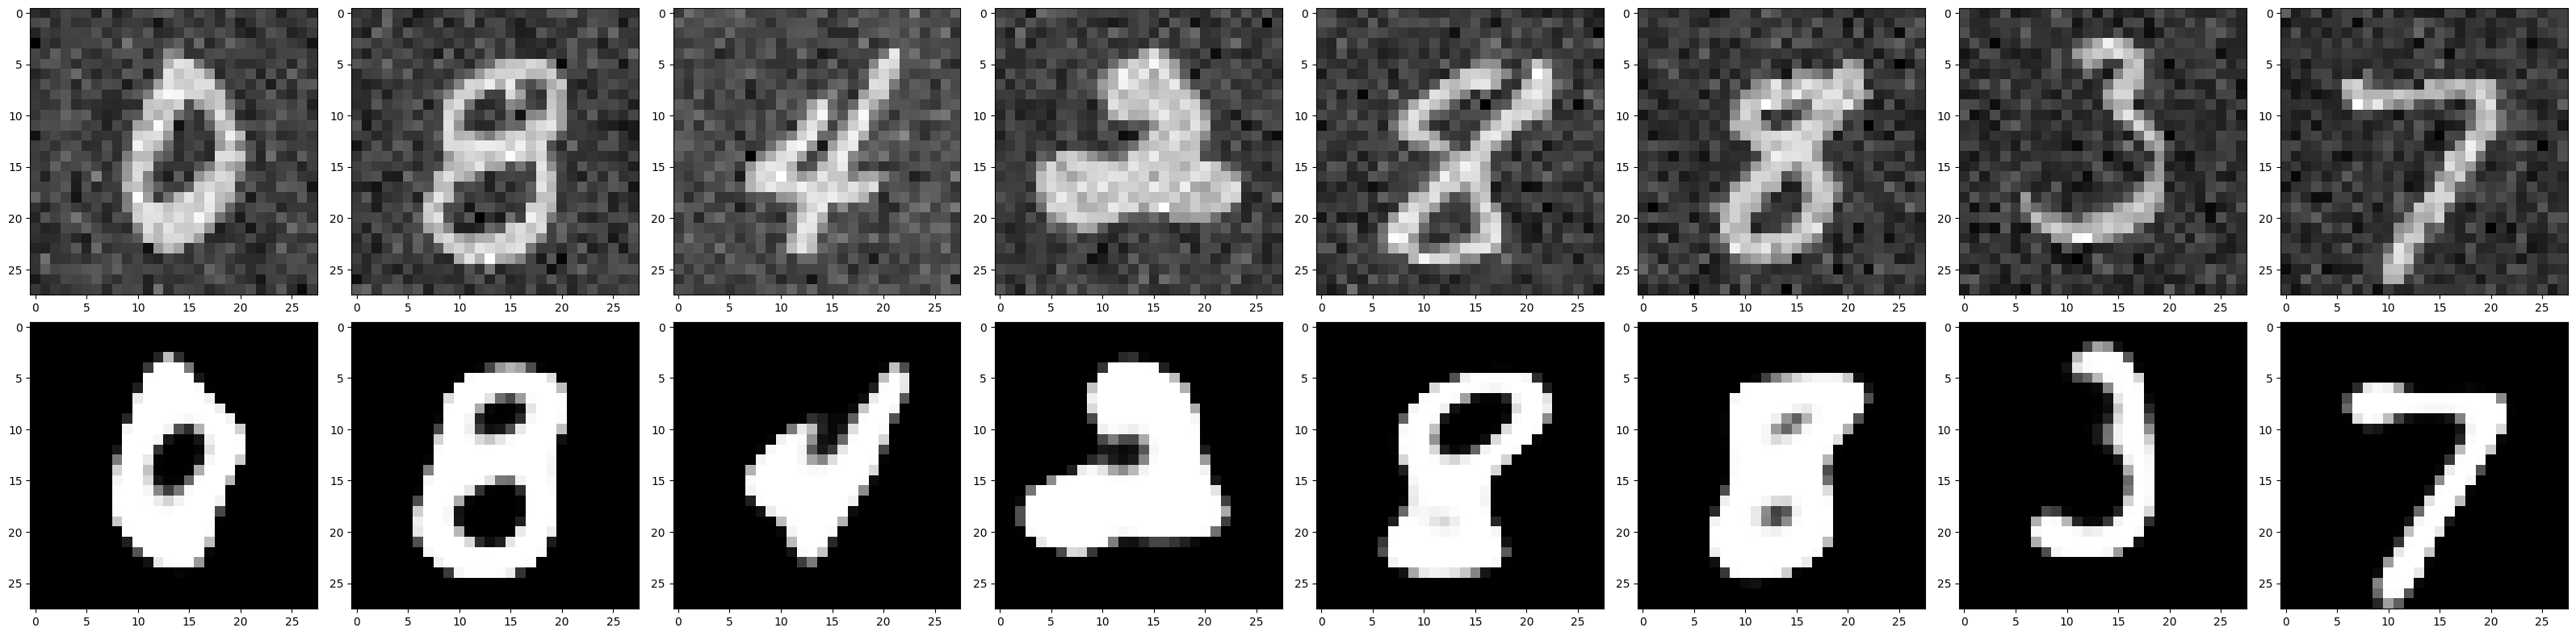

In [187]:
compare_imgs(autoencoder, test_mnist, noise=0.4)